**AutoEncoder**


---



In [ ]:
# Download the mnist dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
batch_size = 128

# image transform
#transform1 = transforms.Compose([transforms.Resize(64),
#                                 transforms.Grayscale(3), #3 channels 
#                                 transforms.ToTensor()])

transform1 = transforms.Compose([transforms.Resize(64),
                                 transforms.ToTensor()])

#transform1 = transforms.ToTensor()

# download train dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                           train=True,
                                           transform=transform1,
                                           download=True)

# download test dataset
test_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                           train=False,
                                           transform=transform1,
                                           download=True)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader =  torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

print(train_dataset.data.shape)
X,y= next(iter(train_loader))
print(X.shape)

In [ ]:
# Create an autoencoder

class AutoEncoder(nn.Module):
  def __init__(self,n_channels,embedding_dim):
    super().__init__()

    self.n_channels = n_channels
    self.embedding_dim = embedding_dim

    self.encoder = nn.Sequential(
      nn.Conv2d(in_channels=self.n_channels,
                out_channels=32,
                kernel_size=(5,5),
                stride=(1,1)),
      nn.ReLU(inplace=True),
      nn.Conv2d(32,32,kernel_size=5,stride=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(32,32,kernel_size=4,stride=2),
      nn.ReLU(inplace=True),
      nn.Conv2d(32,32,kernel_size=3,stride=2),
      nn.ReLU(inplace=True),
      nn.Conv2d(32,self.embedding_dim,kernel_size=4,stride=1)
    )

    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(self.embedding_dim,32,4,1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(32,32,3,2),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(32,32,4,2),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(32,32,5,1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(32,self.n_channels,5,1)
    )
  
  def forward(self,x):
    out = self.encoder(x)
    out = self.decoder(out)
    return out

model = AutoEncoder(1,32)
print(model)



In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(model, (1, 1, 64, 64))

In [ ]:
# Check it out 
X,y= next(iter(train_loader))

X = X.to(device)
y = y.to(device)
model.to(device)

print('input shape:',X.shape)
y_pred = model(X)
print('forward pass (encoded and then decoded):',y_pred.shape)

# You can access the attributes/methods of the model
encoded = model.encoder(X)

print('encoded.shape:',encoded.shape)

decoded = model.decoder(encoded)
print('decoded.shape:',decoded.shape)

In [ ]:
# Train the autoencoder
num_epochs = 50
learning_rate = 1e-3

# set the optimzer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# train
for epoch in range(num_epochs):
  for X,y in train_loader:

    X = X.to(device)
    y = y.to(device)

    z = model.encoder(X)
    output = model.decoder(z)

    loss = 0.5 * (output - X).pow(2).sum() / X.size(0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('Epoch:',epoch,'Loss:',loss)


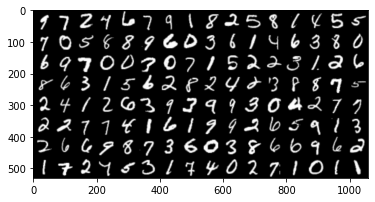

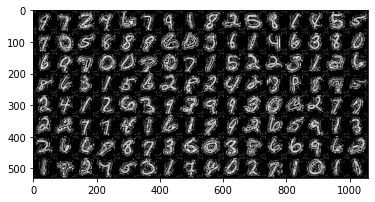

In [ ]:
# Check out an encoded sample
X,y= next(iter(test_loader))
X = X.to(device)

X_encdec = model(X)

from matplotlib import pyplot as plt
import torchvision
from torchvision.utils import make_grid
grid_X = make_grid(X,nrow=16)

img1 = torchvision.transforms.ToPILImage()(grid_X)
plt.figure()
plt.imshow(img1)

grid_X_encdec = make_grid(X_encdec,nrow=16)
img2 = torchvision.transforms.ToPILImage()(grid_X_encdec)
plt.figure()
plt.imshow(img2)

